In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ucsddataset/ucsd_anomaly_dataset/UCSD_Anomaly_Dataset.v1p2/README.txt~
/kaggle/input/ucsddataset/ucsd_anomaly_dataset/UCSD_Anomaly_Dataset.v1p2/README.txt
/kaggle/input/ucsddataset/ucsd_anomaly_dataset/UCSD_Anomaly_Dataset.v1p2/._README.txt
/kaggle/input/ucsddataset/ucsd_anomaly_dataset/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/UCSDped1.m
/kaggle/input/ucsddataset/ucsd_anomaly_dataset/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/._UCSDped1.m
/kaggle/input/ucsddataset/ucsd_anomaly_dataset/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/UCSDped1.m~
/kaggle/input/ucsddataset/ucsd_anomaly_dataset/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test001/079.tif
/kaggle/input/ucsddataset/ucsd_anomaly_dataset/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test001/084.tif
/kaggle/input/ucsddataset/ucsd_anomaly_dataset/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test001/123.tif
/kaggle/input/ucsddataset/ucsd_anomaly_dataset/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test001/130.tif
/kaggle/input/ucsddataset/ucsd_anoma

In [2]:
class Config:
  DATASET_PATH ="/kaggle/input/ucsddataset/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Train"
  SINGLE_TEST_PATH = "/kaggle/input/ucsddataset/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test032"
  BATCH_SIZE = 4
  EPOCHS = 3
  MODEL_PATH = "/kaggle/input/trainedmodel/model.hdf5"

In [3]:

from os import listdir
from os.path import isfile, join, isdir
import numpy as np
from PIL import Image

def get_clips_by_stride(stride, frames_list, sequence_size):
    """ For data augmenting purposes.
    Parameters
    ----------
    stride : int
        The distance between two consecutive frames
    frames_list : list
        A list of sorted frames of shape 256 X 256
    sequence_size: int
        The size of the lstm sequence
    Returns
    -------
    list
        A list of clips , 10 frames each
    """
    clips = []
    sz = len(frames_list)
    clip = np.zeros(shape=(sequence_size, 256, 256, 1))
    cnt = 0
    for start in range(0, stride):
        for i in range(start, sz, stride):
            clip[cnt, :, :, 0] = frames_list[i]
            cnt = cnt + 1
            if cnt == sequence_size:
                clips.append(np.copy(clip))
                cnt = 0
    return clips

def get_training_set():
    """
    Returns
    -------
    list
        A list of training sequences of shape (NUMBER_OF_SEQUENCES,SINGLE_SEQUENCE_SIZE,FRAME_WIDTH,FRAME_HEIGHT,1)
    """
    clips = []
    # loop over the training folders (Train000,Train001,..)
    for f in sorted(listdir(Config.DATASET_PATH)):
        directory_path = join(Config.DATASET_PATH, f)
        if isdir(directory_path):
            all_frames = []
            # loop over all the images in the folder (0.tif,1.tif,..,199.tif)
            for c in sorted(listdir(directory_path)):
                img_path = join(directory_path, c)
                if str(img_path)[-3:] == "tif":
                    img = Image.open(img_path).resize((256, 256))
                    img = np.array(img, dtype=np.float32) / 256.0
                    all_frames.append(img)
            # get the 10-frames sequences from the list of images after applying data augmentation
            for stride in range(1, 3):
                clips.extend(get_clips_by_stride(stride=stride, frames_list=all_frames, sequence_size=10))
    return clips


In [4]:
import tensorflow_io as tfio



/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [5]:
import keras
from keras.layers import Conv2DTranspose, ConvLSTM2D, BatchNormalization, TimeDistributed, Conv2D, LayerNormalization
from keras.models import Sequential, load_model
def get_model(reload_model=True):
    """
    Parameters
    ----------
    reload_model : bool
        Load saved model or retrain it
    """
    if not reload_model:
        return load_model(Config.MODEL_PATH,custom_objects={'LayerNormalization': LayerNormalization})
    training_set = get_training_set()
    training_set = np.array(training_set)
    training_set = training_set.reshape(-1,10,256,256,1)
    seq = Sequential()
    seq.add(TimeDistributed(Conv2D(128, (11, 11), strides=4, padding="same"), batch_input_shape=(None, 10, 256, 256, 1)))
    seq.add(LayerNormalization())
    seq.add(TimeDistributed(Conv2D(64, (5, 5), strides=2, padding="same")))
    seq.add(LayerNormalization())
    # # # # #
    seq.add(ConvLSTM2D(64, (3, 3), padding="same", return_sequences=True))
    seq.add(LayerNormalization())
    seq.add(ConvLSTM2D(32, (3, 3), padding="same", return_sequences=True))
    seq.add(LayerNormalization())
    seq.add(ConvLSTM2D(64, (3, 3), padding="same", return_sequences=True))
    seq.add(LayerNormalization())
    # # # # #
    seq.add(TimeDistributed(Conv2DTranspose(64, (5, 5), strides=2, padding="same")))
    seq.add(LayerNormalization())
    seq.add(TimeDistributed(Conv2DTranspose(128, (11, 11), strides=4, padding="same")))
    seq.add(LayerNormalization())
    seq.add(TimeDistributed(Conv2D(1, (11, 11), activation="sigmoid", padding="same")))
    print(seq.summary())
    seq.compile(loss='mse', optimizer=keras.optimizers.Adam(lr=1e-4, decay=1e-5, epsilon=1e-6))
    seq.fit(training_set, training_set,
            batch_size=Config.BATCH_SIZE, epochs=Config.EPOCHS, shuffle=False)
    seq.save(Config.MODEL_PATH)
    return seq

In [6]:
def get_single_test():
    sz = 200
    test = np.zeros(shape=(sz, 256, 256, 1))
    cnt = 0
    for f in sorted(listdir(Config.SINGLE_TEST_PATH)):
        if str(join(Config.SINGLE_TEST_PATH, f))[-3:] == "tif":
            img = Image.open(join(Config.SINGLE_TEST_PATH, f)).resize((256, 256))
            img = np.array(img, dtype=np.float32) / 256.0
            test[cnt, :, :, 0] = img
            cnt = cnt + 1
    return test

In [7]:
import matplotlib.pyplot as plt

def evaluate():
    model = get_model(False)
    print("got model")
    test = get_single_test()
    print(test.shape)
    sz = test.shape[0] - 10 + 1
    sequences = np.zeros((sz, 10, 256, 256, 1))
    # apply the sliding window technique to get the sequences
    for i in range(0, sz):
        clip = np.zeros((10, 256, 256, 1))
        for j in range(0, 10):
            clip[j] = test[i + j, :, :, :]
        sequences[i] = clip

    print("got data")
    # get the reconstruction cost of all the sequences
    reconstructed_sequences = model.predict(sequences,batch_size=4)
    sequences_reconstruction_cost = np.array([np.linalg.norm(np.subtract(sequences[i],reconstructed_sequences[i])) for i in range(0,sz)])
    sa = (sequences_reconstruction_cost - np.min(sequences_reconstruction_cost)) / np.max(sequences_reconstruction_cost)
    sr = 1.0 - sa

    # plot the regularity scores
    plt.plot(sr)
    plt.ylabel('regularity score Sr(t)')
    plt.xlabel('frame t')
    plt.show()


got model
(200, 256, 256, 1)
got data
48/48 [==============================] - 533s 11s/step


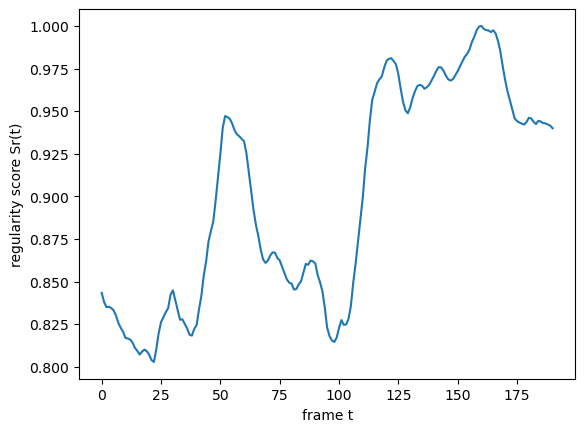

In [8]:
evaluate()